### Laboratorium 4 - zadania

Jeśli nie posiadasz jeszcze pakietu `skimage`, zainstaluj go poniższym poleceniem:

In [1]:
!pip install scikit-image

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from skimage.io import imread
from skimage.util import img_as_float

#### Zadanie 1

Dane są obrazy `hare` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie jednolitych  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC - [`skimage.segmentation.slic`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic) - (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja [`mark_boundaries`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries).

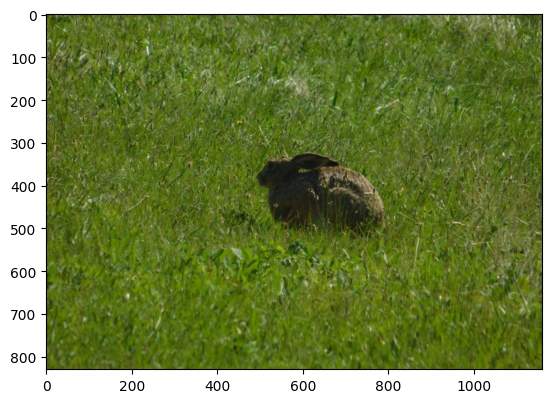

In [2]:
hare = cv2.imread('Zajac_kolor.jpg')[..., ::-1]
plt.imshow(hare);

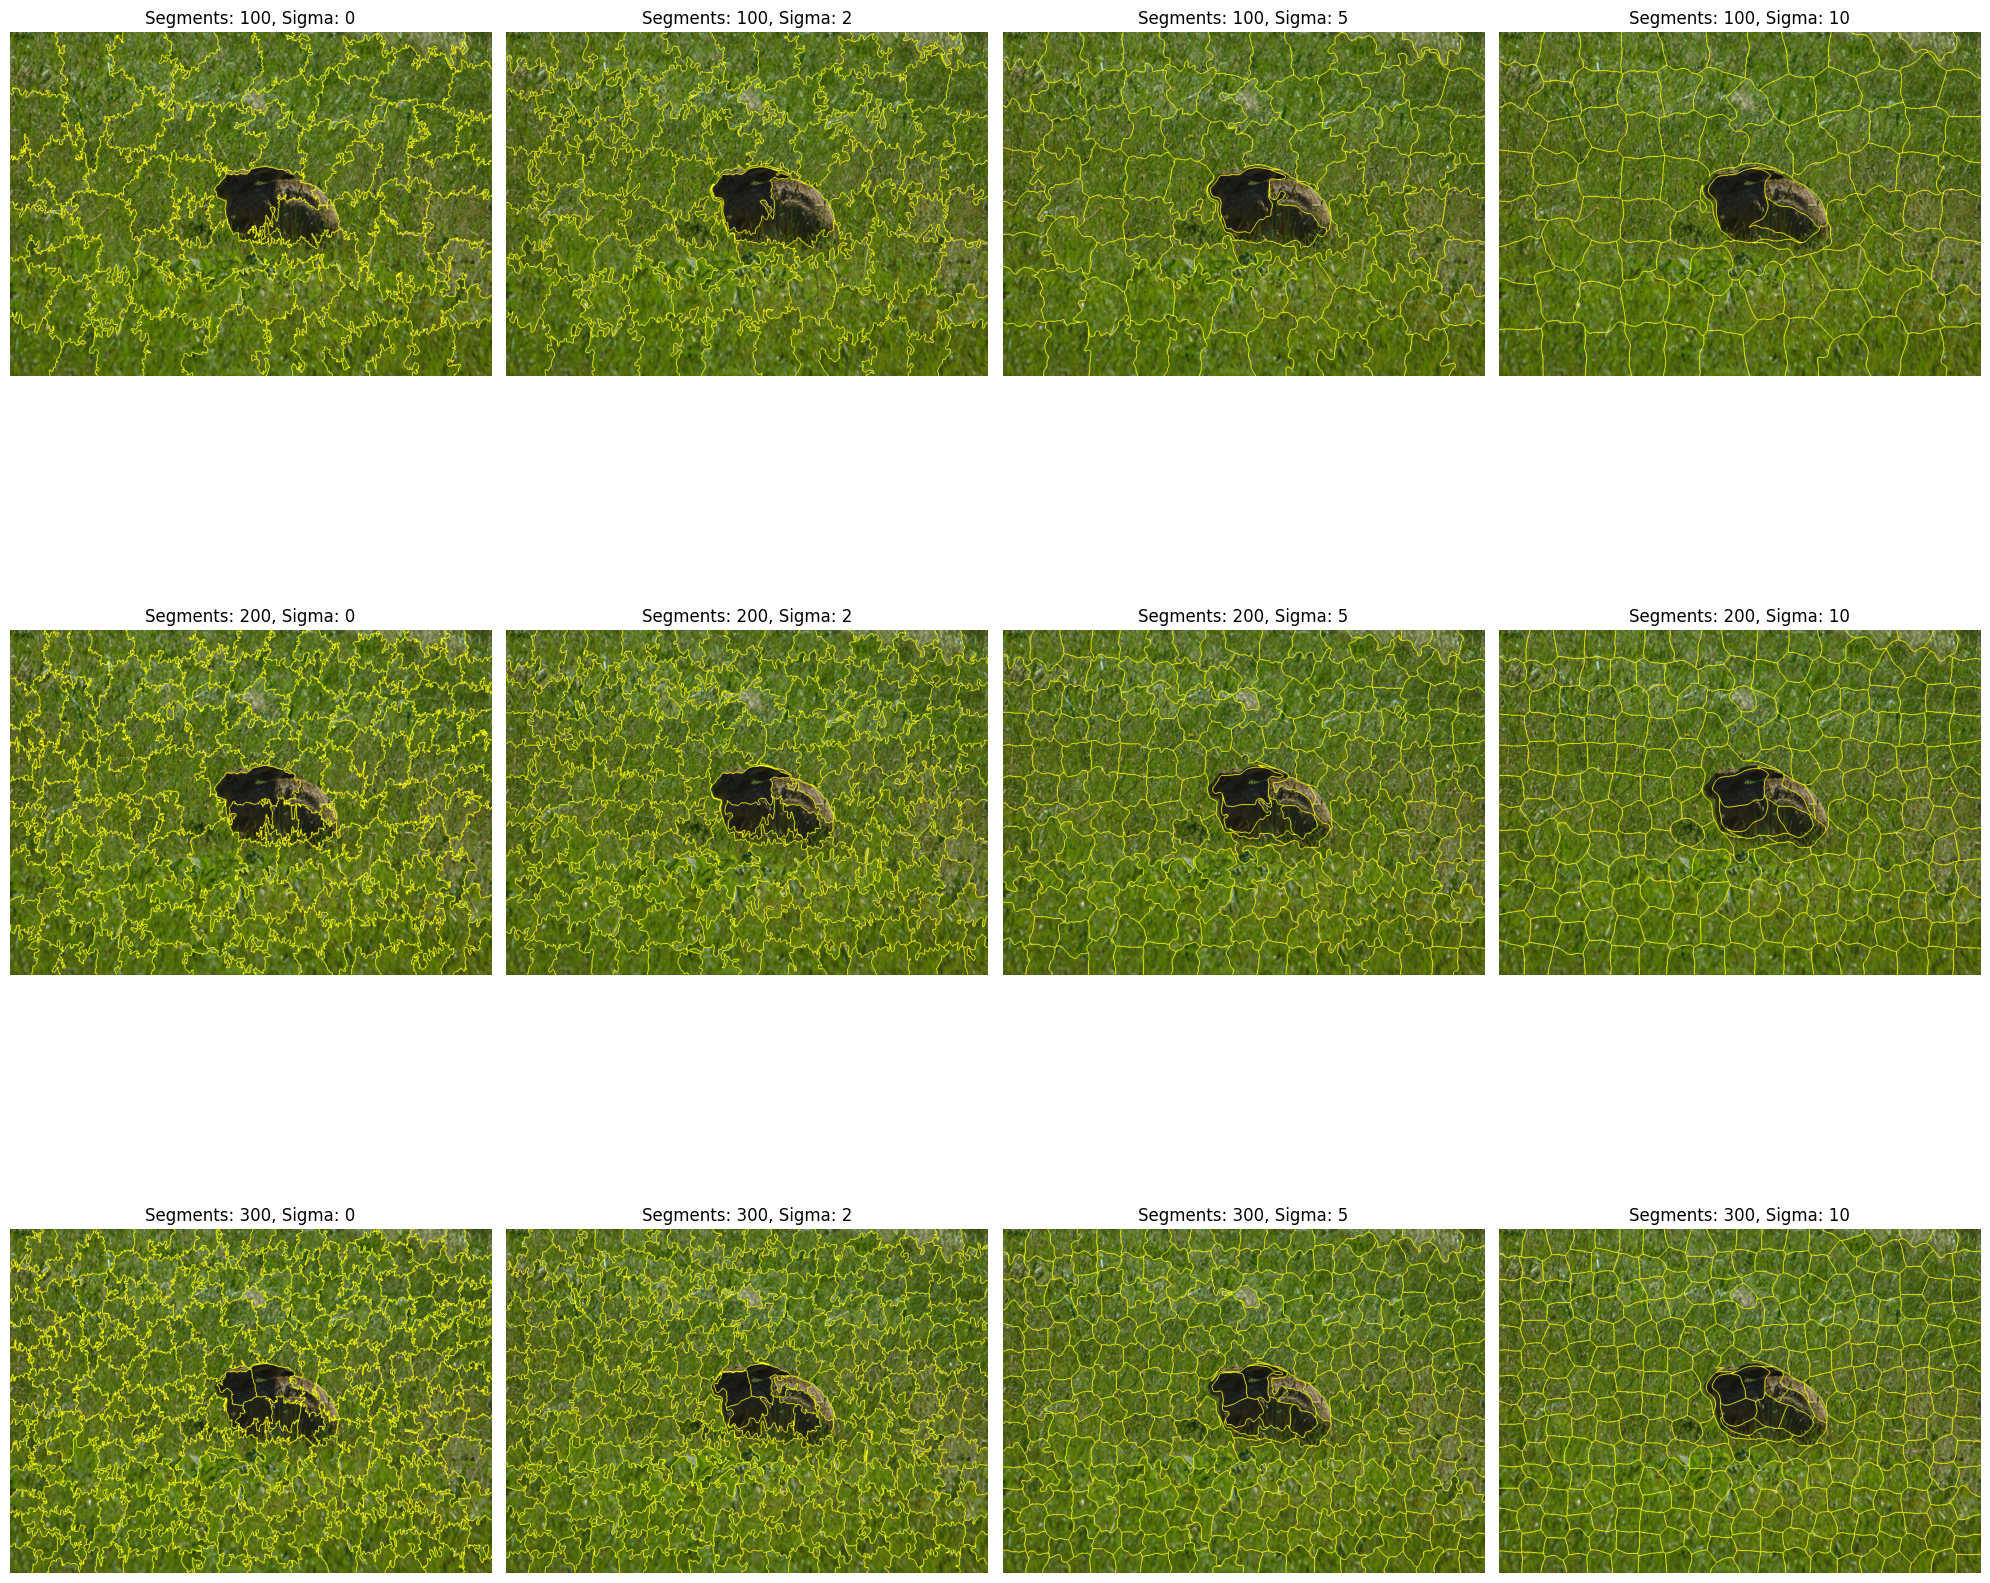

In [10]:
image = img_as_float(hare)

num_segments_list = [100, 200, 300]  
sigma_list = [0, 2, 5, 10]  

results = {}

for num_segments in num_segments_list:
    for sigma in sigma_list:
        segments = slic(image, n_segments=num_segments, sigma=sigma, start_label=1)

        results[(num_segments, sigma)] = segments

fig, axes = plt.subplots(3, 4, figsize=(20, 20))
ax = axes.ravel()

for idx, ((num_segments, sigma), segments) in enumerate(results.items()):
    ax[idx].imshow(mark_boundaries(image, segments))
    ax[idx].set_title(f'Segments: {num_segments}, Sigma: {sigma}')
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

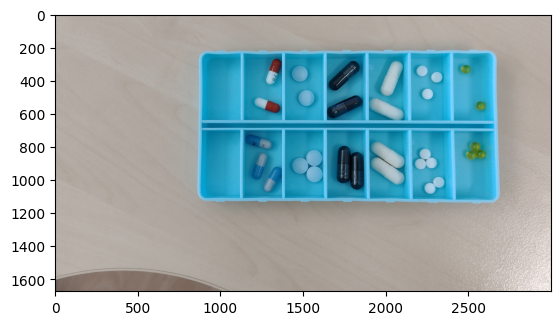

In [12]:
pills = cv2.imread('pills.png')[..., ::-1]
plt.imshow(pills);

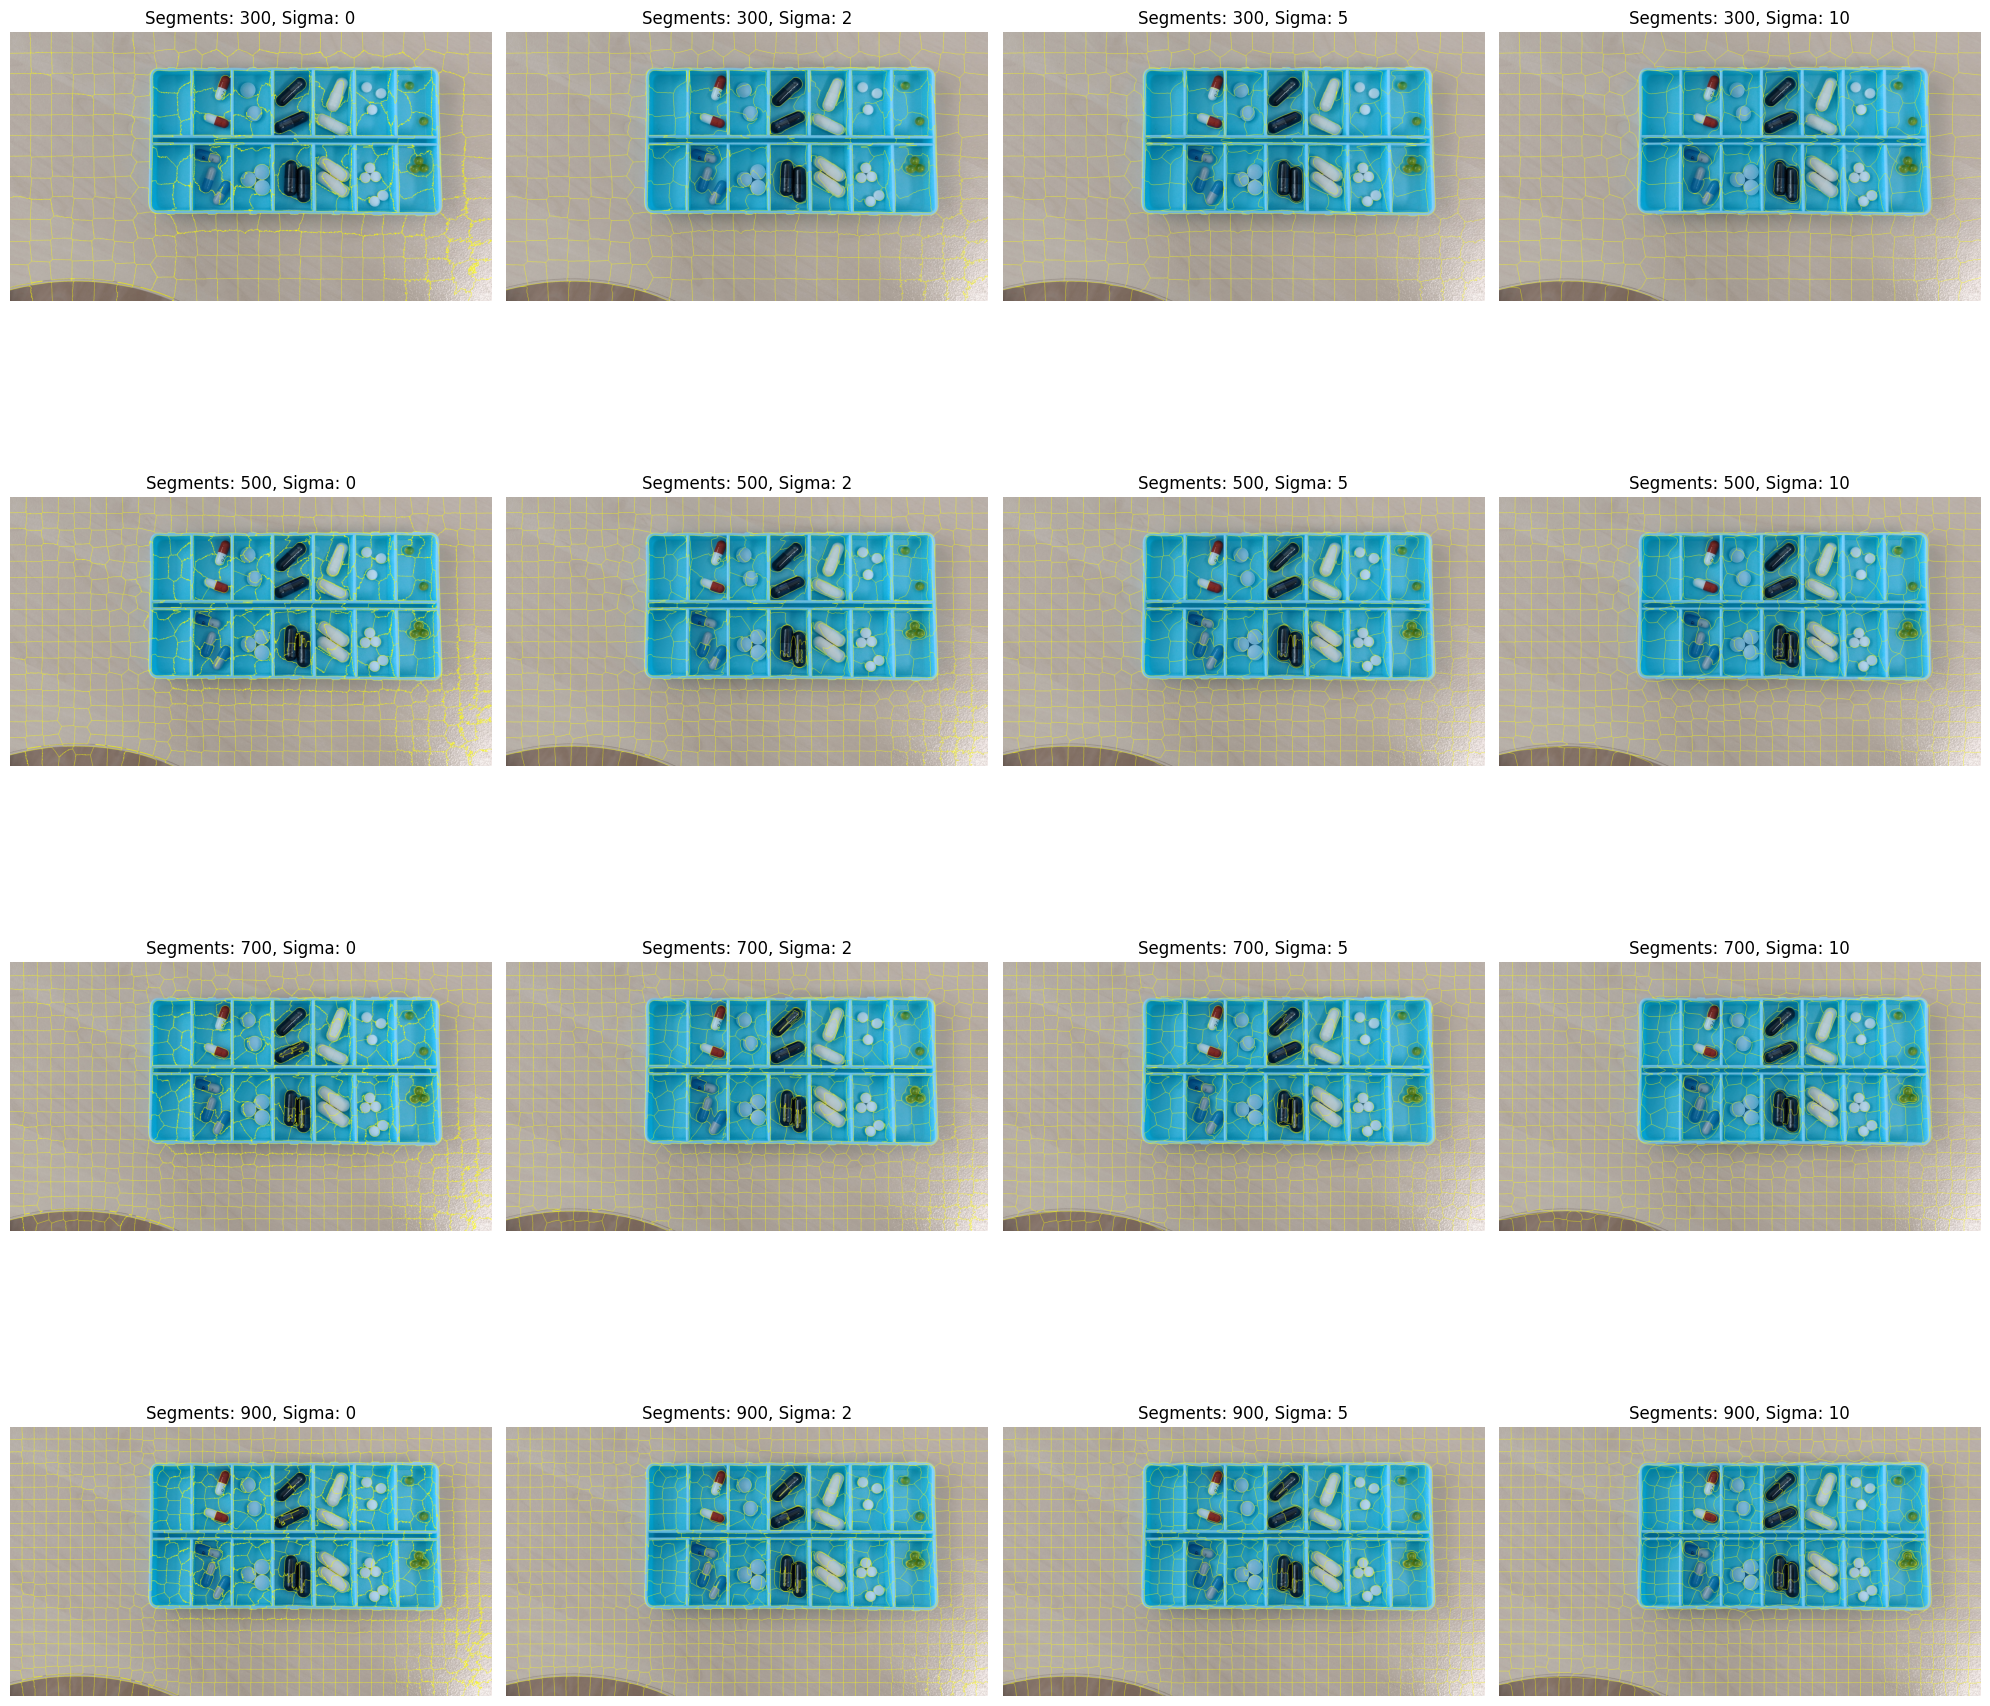

In [13]:
image = img_as_float(pills)

num_segments_list = [300, 500, 700, 900]  
sigma_list = [0, 2, 5, 10]  

results = {}

for num_segments in num_segments_list:
    for sigma in sigma_list:
        segments = slic(image, n_segments=num_segments, sigma=sigma, start_label=1)

        results[(num_segments, sigma)] = segments

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
ax = axes.ravel()

for idx, ((num_segments, sigma), segments) in enumerate(results.items()):
    ax[idx].imshow(mark_boundaries(image, segments))
    ax[idx].set_title(f'Segments: {num_segments}, Sigma: {sigma}')
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

#### Zadanie 2

Dla obrazu `hare` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie zająca, drugi zawierający wyłącznie trawę. Wykorzystaj dowolny algorytm klasteryzacji (np. [`cv2.kmeans`](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88)) by pogrupować superpiksele w dwie klasy, używając *cech* superpikseli uzyskanych w zadaniu 1 jako danych wejściowych. Najprostszymi cechami, którymi można opisać superpiksele, są np. średnie wartości składowych barwy (pikseli, z których składa się superpiksel) - od nich zacznij. Wersja "na piątkę": zaproponuj swoją własną cechę i rozszerz o nią reprezentację superpiksela, a następnie powtórz grupowanie.

Zaprezentuj wyniki najlepiej za pomocą `mark_boundaries` albo po prostu wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać: ```A[B==5] = 0```. Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

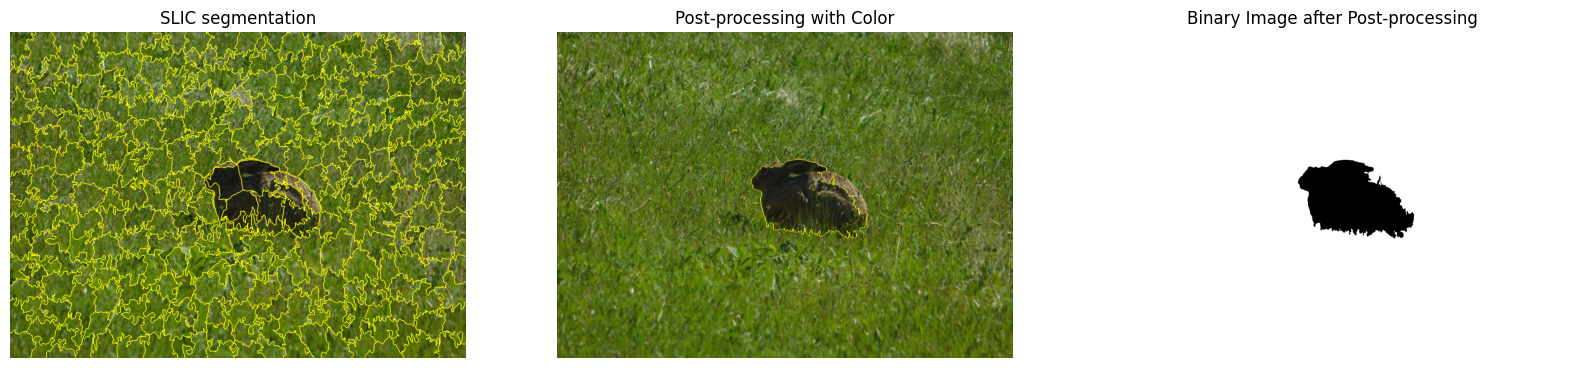

In [9]:
from skimage import color

image = img_as_float(hare)

segments = slic(image, n_segments=300, sigma=1, start_label=1)

def calculate_avg_color(image, segments):
    average_colors = np.zeros((np.max(segments) + 1, 3))
    for segment_val in np.unique(segments):
        mask = segments == segment_val
        average_colors[segment_val, :] = np.mean(image[mask], axis=0)
    return average_colors

image_color = color.rgb2lab(image) if len(image.shape) == 3 else image

avg_colors = calculate_avg_color(image_color, segments)

data = avg_colors.reshape(-1, 3).astype(np.float32)

_, labels, _ = cv2.kmeans(
    data=data,
    K=2,
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),
    attempts=1,
    flags=cv2.KMEANS_RANDOM_CENTERS
)

labels = labels.flatten()

postprocessed = np.zeros_like(segments)
for i in range(labels.shape[0]):
    postprocessed[segments == i] = labels[i]

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(mark_boundaries(image, segments))
ax[0].set_title("SLIC segmentation")
ax[0].axis('off')

ax[1].imshow(mark_boundaries(image, postprocessed))
ax[1].set_title("Post-processing with Color")
ax[1].axis('off')

ax[2].imshow(cv2.bitwise_not(postprocessed), 'gray')
ax[2].set_title("Binary Image after Post-processing")
ax[2].axis('off')

plt.show()


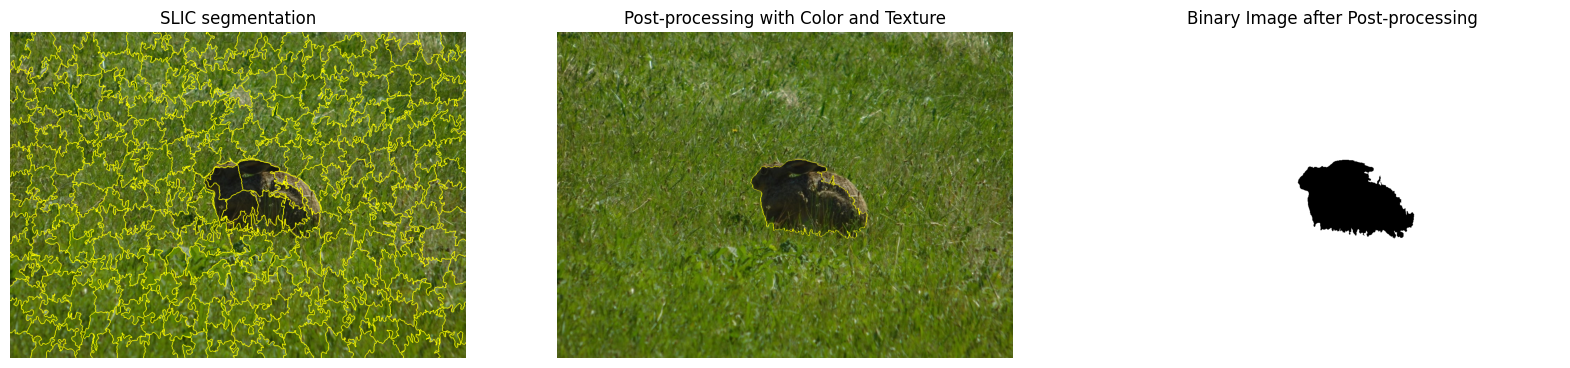

In [17]:
from skimage.feature import local_binary_pattern

image = img_as_float(hare) 
segments = slic(image, n_segments=300, sigma=1, start_label=1)

def calculate_avg_color(image, segments):
    average_colors = np.zeros((np.max(segments) + 1, 3))
    for segment_val in np.unique(segments):
        mask = segments == segment_val
        average_colors[segment_val, :] = np.mean(image[mask], axis=0)
    return average_colors

def calculate_avg_lbp(image, segments):
    avg_lbp = np.zeros(np.max(segments) + 1)
    for segment_val in np.unique(segments):
        mask = segments == segment_val
        avg_lbp[segment_val] = np.mean(image[mask])
    return avg_lbp

image_color = color.rgb2lab(image) if len(image.shape) == 3 else image
avg_colors = calculate_avg_color(image_color, segments)

gray_image = color.rgb2gray(image)
radius = 8
n_points = 2 * radius
lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
avg_lbp = calculate_avg_lbp(lbp, segments)

extended_data = np.hstack((avg_colors, avg_lbp.reshape(-1, 1))).astype(np.float32)

_, labels, _ = cv2.kmeans(
    data=extended_data,
    K=2,
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),
    attempts=1,
    flags=cv2.KMEANS_RANDOM_CENTERS
)

labels = labels.flatten()

postprocessed = np.zeros_like(segments)
for i in range(labels.shape[0]):
    postprocessed[segments == i] = labels[i]

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(mark_boundaries(image, segments))
ax[0].set_title("SLIC segmentation")
ax[0].axis('off')

ax[1].imshow(mark_boundaries(image, postprocessed))
ax[1].set_title("Post-processing with Color and Texture")
ax[1].axis('off')

ax[2].imshow(cv2.bitwise_not(postprocessed), 'gray')
ax[2].set_title("Binary Image after Post-processing")
ax[2].axis('off')

plt.show()



Możesz wykorzystać poniższy snippet by zredukować wynik segmentacji SLIC (`segments`) w oparciu o klasteryzację k-średnich (`labels`):

In [ ]:
postprocessed = np.zeros_like(segments)
for i in range(labels.shape[0]):
    postprocessed[segments==i] = labels[i] # jeśli używamy indeksowania od 0 w SLIC
    postprocessed[segments==i+1] = labels[i] # jeśli używamy indeksowania od 1